In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# **Predicting Subscriptions**

A research group in Computer Science at UBC wants to predict what kinds of behaviours and player characteristics are more likely to subscribe to a gaming-related newspaper. In this report, we are going to explore if age and hours played affect whether someone will subscribe to the newsletter. We will be analyzing data from the `players.csv` dataframe. This dataframe contains information such as player experience, hours played, gender, age, and more. In this report, we will create a K-nearest neighbours (KNN) classification model to identify patterns and relationships so that we can make accurate predictions.

# **Hypthothesis**
In this report, we are going to find out if the Age of the player and the hours played can predict whether someone will subscribe to a gaming newspaper using the `players.csv` dataset. I believe that the younger population will be more likely to subscribe to a gaming-related newspaper, as typically, video games are more popular among younger people. However, I believe that the population under 15 years old will not be likely to subscribe. Assuming this newspaper subscription costs money, the population under 15 will most likely not be able to afford it unless it is paid for by their parents. I also believe, the more hours spent playing the game, the more likely the person will be to subscribe. The longer someone spends playing a game, the more invested they will be. If they are invested in the game, it is expected that they will subscribe. 



In [19]:
set.seed(123)
players<-read_csv("players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17


After loading the `players.csv` data, we will now select the columns we need: `Age`, `experience`, `subscribe`. Then we will remove the `NA` values. This will remove rows of the `Age` or `played_hours` columns that do not contain or are missing data. This is important as KNN functions require complete cases. Finally, we need to mutate the `subscribe` column into a factor data type. This is necessary for the classification models we will be doing later on.

In [20]:
set.seed(123)
players<-players|>
select(subscribe, played_hours, Age)|>
filter(!is.na(Age), !is.na(played_hours))|>
mutate(subscribe = as_factor(subscribe))
players

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
⋮,⋮,⋮
TRUE,0.0,20
TRUE,0.0,17
FALSE,0.3,22


We are now going to create a histogram graph. This histogram is going to plot the `Age` of the person and their subscription status (`subscribe`). This graph will coloured by subscription status

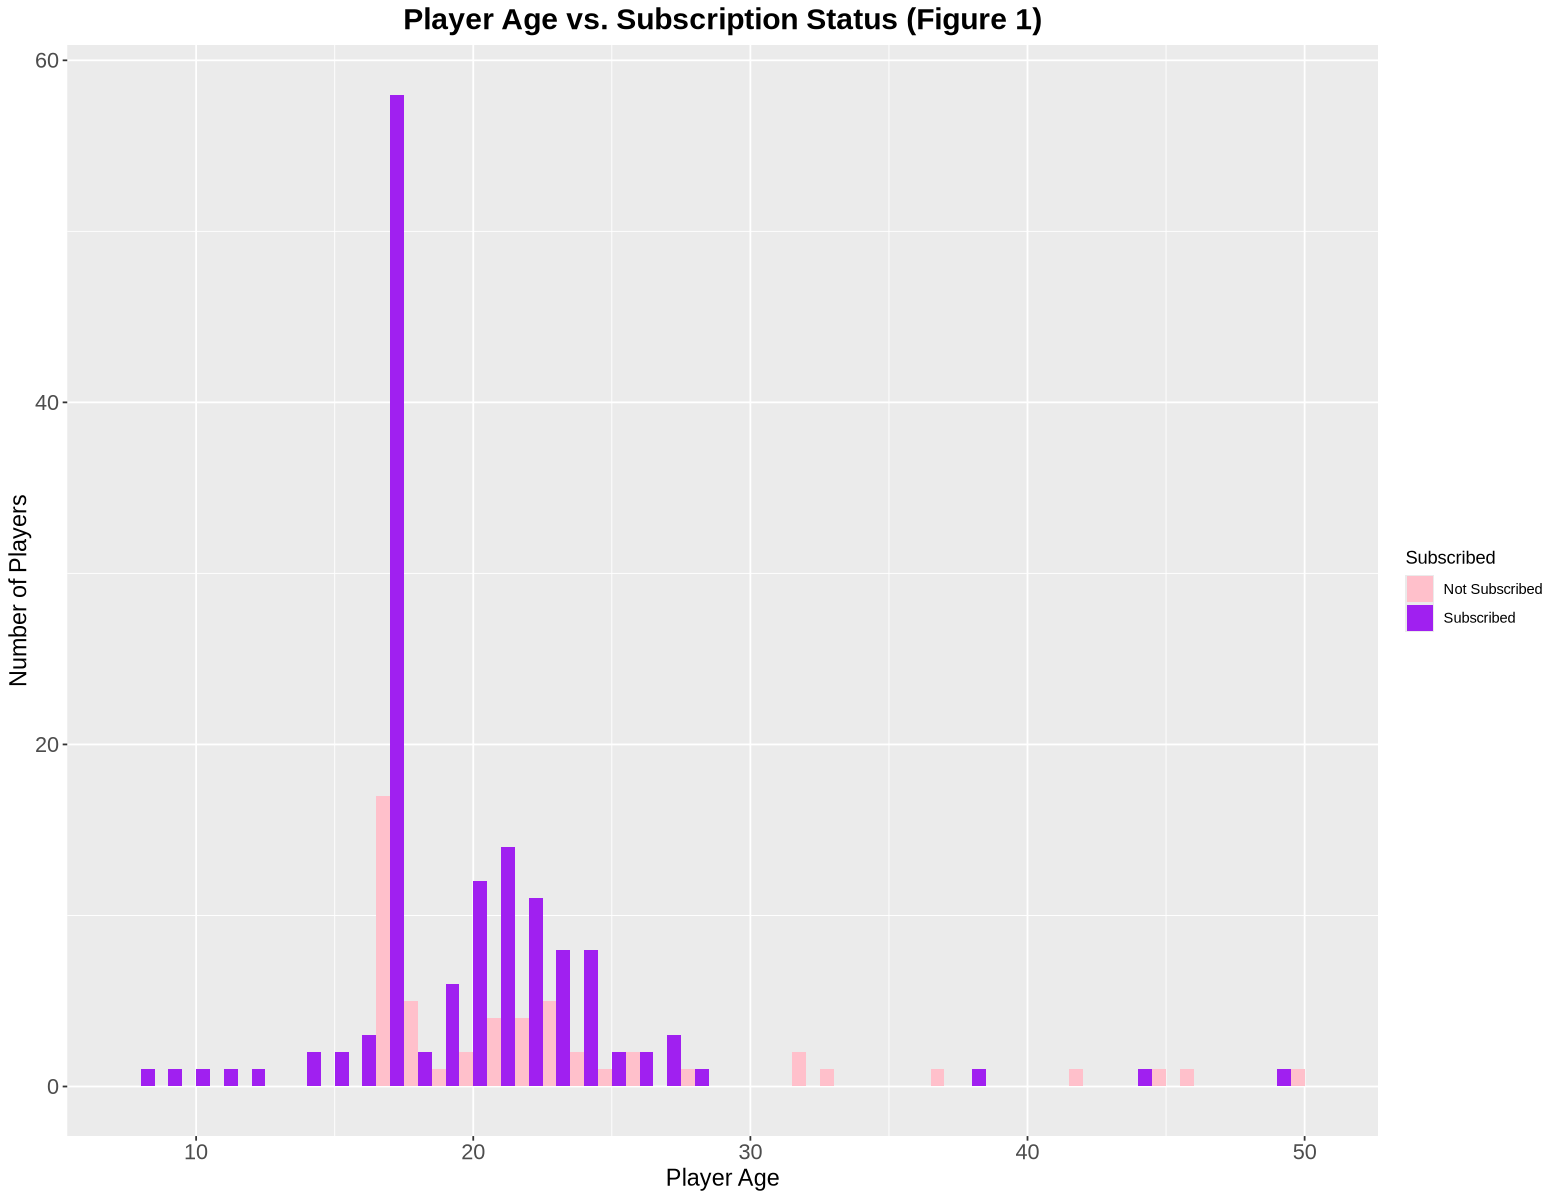

In [21]:
set.seed(123)
 options(repr.plot.width = 13, repr.plot.height = 10) 
player_age_plot<- players|> 
ggplot(aes(x = Age, fill = subscribe)) +
geom_histogram(position = "dodge", binwidth=1) + 
labs(x = "Player Age", y = "Number of Players", fill = "Subscribed",
title = "Player Age vs. Subscription Status (Figure 1)") +
scale_fill_manual(values = c("FALSE" = "pink", "TRUE" = "purple"),labels = c("Not Subscribed", "Subscribed")) +
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
player_age_plot

Figure 1 shows the distribution of player ages, separated by subscription status. The purple bars represent the subscribed population while the pink bars represent the not subscribed population. Based on the graph you can see that the majority of people who subscribe to gaming related newspappers are younger. The majority of subscribers are under the age of 30 years old. 

Next we will create another histogram but this time we will be plotting `played_hours` and subscription status (`subscribe`). This graph will also have subscription status seperated by colour

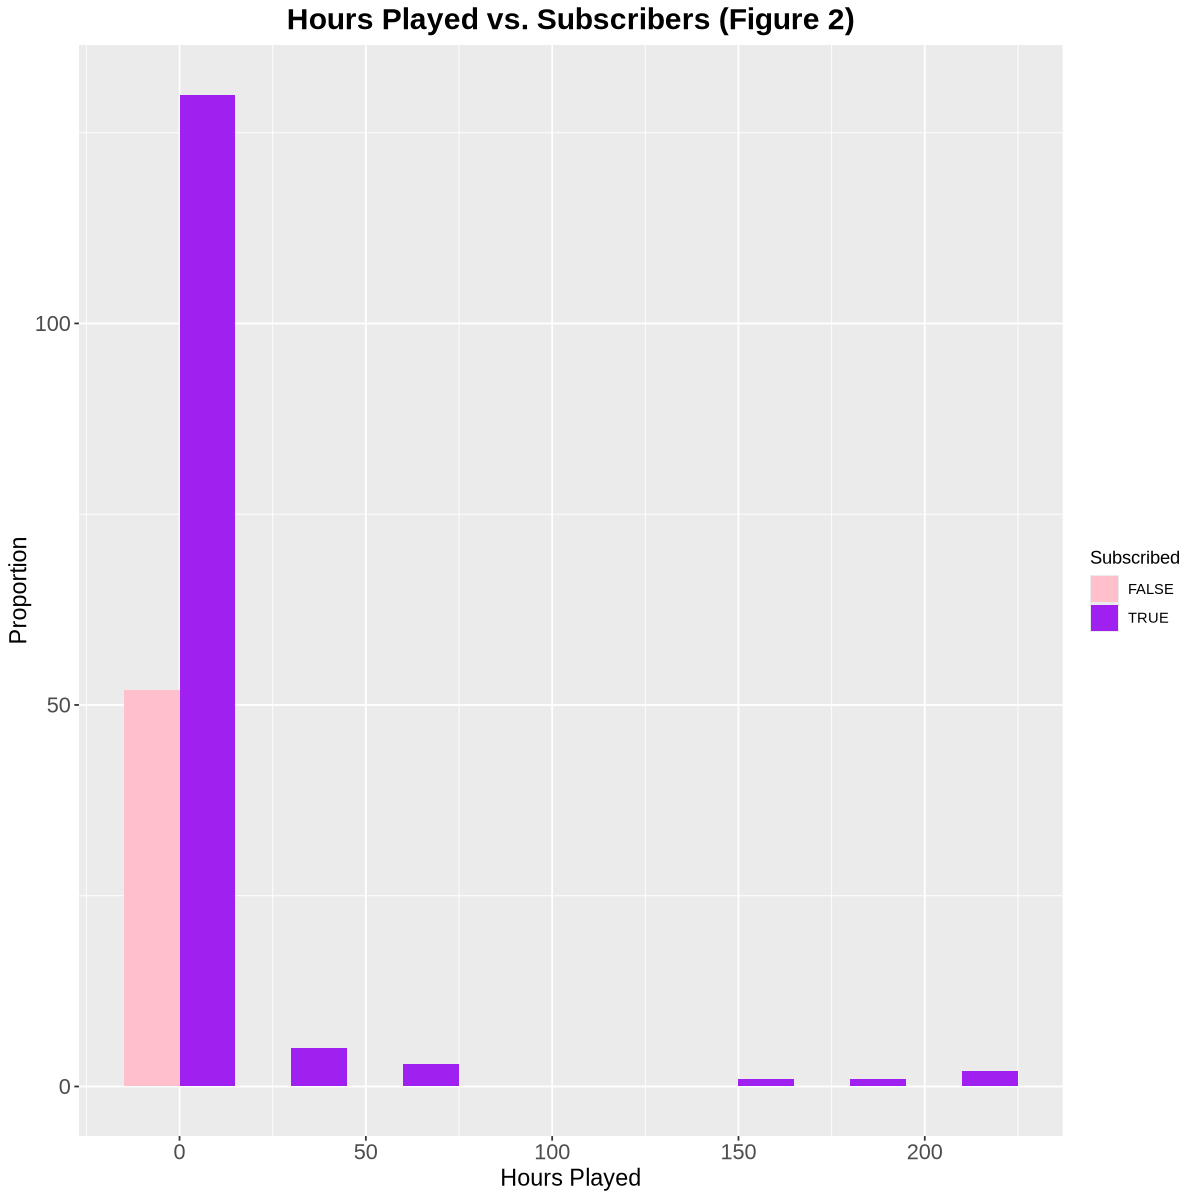

In [22]:
set.seed(123)
options(repr.plot.width = 10, repr.plot.height = 10) 
hours_played_plot<-players|>
ggplot(aes(x=played_hours, fill=subscribe))+
geom_histogram(position="dodge", binwidth=30)+
labs(x="Hours Played", y="Proportion", fill="Subscribed")+
scale_fill_manual(values = c("TRUE" = "purple", "FALSE" = "pink")) +
ggtitle("Hours Played vs. Subscribers (Figure 2)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
hours_played_plot

Figure 2 shows the distribution of hours played, seperated by subscription status, The purple bars represent the subscribed population while the pink bars represent the not subscribed population. Based on the graph, all of those who don't subscribe to the newspaper played the least amount of hours. This graph also shows that people who play more hours of minecraft are more likely to be subscribed. 

Now that we know that there is a correlation between age and subscription and hours played and subscription, we are going to create a knn-classfication model. To do this we are going to start with splitting the data. We are going to split the data into 75% `training_data` and 25% `testing_data`

In [23]:
set.seed(123)
data_split<-initial_split(players, prop = 0.75, strata = subscribe)
data_split
training_data<-training(data_split)
training_data
testing_data<-testing(data_split)
testing_data

<Training/Testing/Total>
<145/49/194>

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,22
FALSE,0.1,17
FALSE,0.0,23
FALSE,0.0,33
FALSE,1.4,25
⋮,⋮,⋮
TRUE,0.8,22
TRUE,32.0,22
TRUE,0.1,44


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
FALSE,0.0,21
TRUE,0.0,17
⋮,⋮,⋮
TRUE,0.4,17
FALSE,0.2,17
TRUE,0.0,17


Now we are going to create a `recipe`. In this step we are seeing if `Age` and `played_hours` can predict `subscribe`. Then we are going to scale and center the data by using the `step_scale(all_predictors())` and `step_center(all_predictors())` functions. 

In [24]:
set.seed(123)
subscribe_recipe<-recipe(subscribe~Age+played_hours, data=training_data)|>
step_scale(all_predictors())|>
step_center(all_predictors())
subscribe_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Operations 

• Scaling for: all_predictors()

• Centering for: all_predictors()



After splitting the data into training and testing, we are now going to create our K-nearest neighbour classifier. To do this we will be using the `nearest_neighbor()` function. Since we don't know what our k value is we will use `tune()`. The computational engine will be set as "kknn" for the training model. Lastly, we will set the `set_mode()` function as a classification problem.

In [25]:
set.seed(123)
subscribe_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
set_engine("kknn")|>
set_mode("classification")
subscribe_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we are going to train the classifier with the training data using the `workflow()` function. This step will allow for us to bundle together all parts of the modelling process into one object

In [26]:
set.seed(123)
subscribe_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
fit(data=training_data)
subscribe_fit

Warning message:
“tune samples were requested but there were 145 rows in the data. 140 will be used.”


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(tune(),     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 140

We will now do a cross-validation using the `vfold_cv` function. Set the `strata` argument to `subscribe`. For this project, we will be doing a 5-fold cross-validation test. This will split the training data into 5 parts: 4 parts for training and 1 part for testing. Then it will average the results. 

In [27]:
set.seed(123)
subscribe_vfold<-vfold_cv(training_data, v = 5, strata = subscribe)
subscribe_vfold

Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
Warning message:
“`optional` is kept for consistency with the underlying class but TRUE values will be ignored.”
ERROR while rich displaying an object: Error in (function (..., row.names = NULL, check.rows = FALSE, check.names = TRUE, : arguments imply differing number of rows: 115, 116, 117

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NUL

we are now going to create a `tibble` and resample our data. By resampling, it gives us better preformance estimates and avoids overfitting.

In [28]:
set.seed(123)
k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

subscribe_resample_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(subscribe_spec)|>
tune_grid(resamples=subscribe_vfold, grid=k_vals)|>
collect_metrics()
subscribe_resample_fit

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4823153,5,0.05714033,Preprocessor1_Model01
1,roc_auc,binary,0.5045455,5,0.06053496,Preprocessor1_Model01
2,accuracy,binary,0.4756486,5,0.05401092,Preprocessor1_Model02
2,roc_auc,binary,0.5361279,5,0.03264068,Preprocessor1_Model02
3,accuracy,binary,0.5788670,5,0.03091701,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,roc_auc,binary,0.4965986,5,0.02757122,Preprocessor1_Model08
9,accuracy,binary,0.5926765,5,0.04070970,Preprocessor1_Model09
9,roc_auc,binary,0.5014881,5,0.01413299,Preprocessor1_Model09


Then we are going to test the accuracy of our resample and evaluate how well it preforms. 

In [29]:
set.seed(123)
accuracy <- subscribe_resample_fit |> 
       filter(.metric=="accuracy")
accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4823153,5,0.05714033,Preprocessor1_Model01
2,accuracy,binary,0.4756486,5,0.05401092,Preprocessor1_Model02
3,accuracy,binary,0.5788670,5,0.03091701,Preprocessor1_Model03
4,accuracy,binary,0.5239245,5,0.02575105,Preprocessor1_Model04
5,accuracy,binary,0.5786371,5,0.02283550,Preprocessor1_Model05
6,accuracy,binary,0.5648440,5,0.03369167,Preprocessor1_Model06
7,accuracy,binary,0.5717406,5,0.04698515,Preprocessor1_Model07
8,accuracy,binary,0.5786371,5,0.04413992,Preprocessor1_Model08
9,accuracy,binary,0.5926765,5,0.04070970,Preprocessor1_Model09


Now that we have the accuracy of our new data, we are going to create a line graph outlining the estimated accuracy vs the neighbours. We are doing this to see what value of k is the best. 

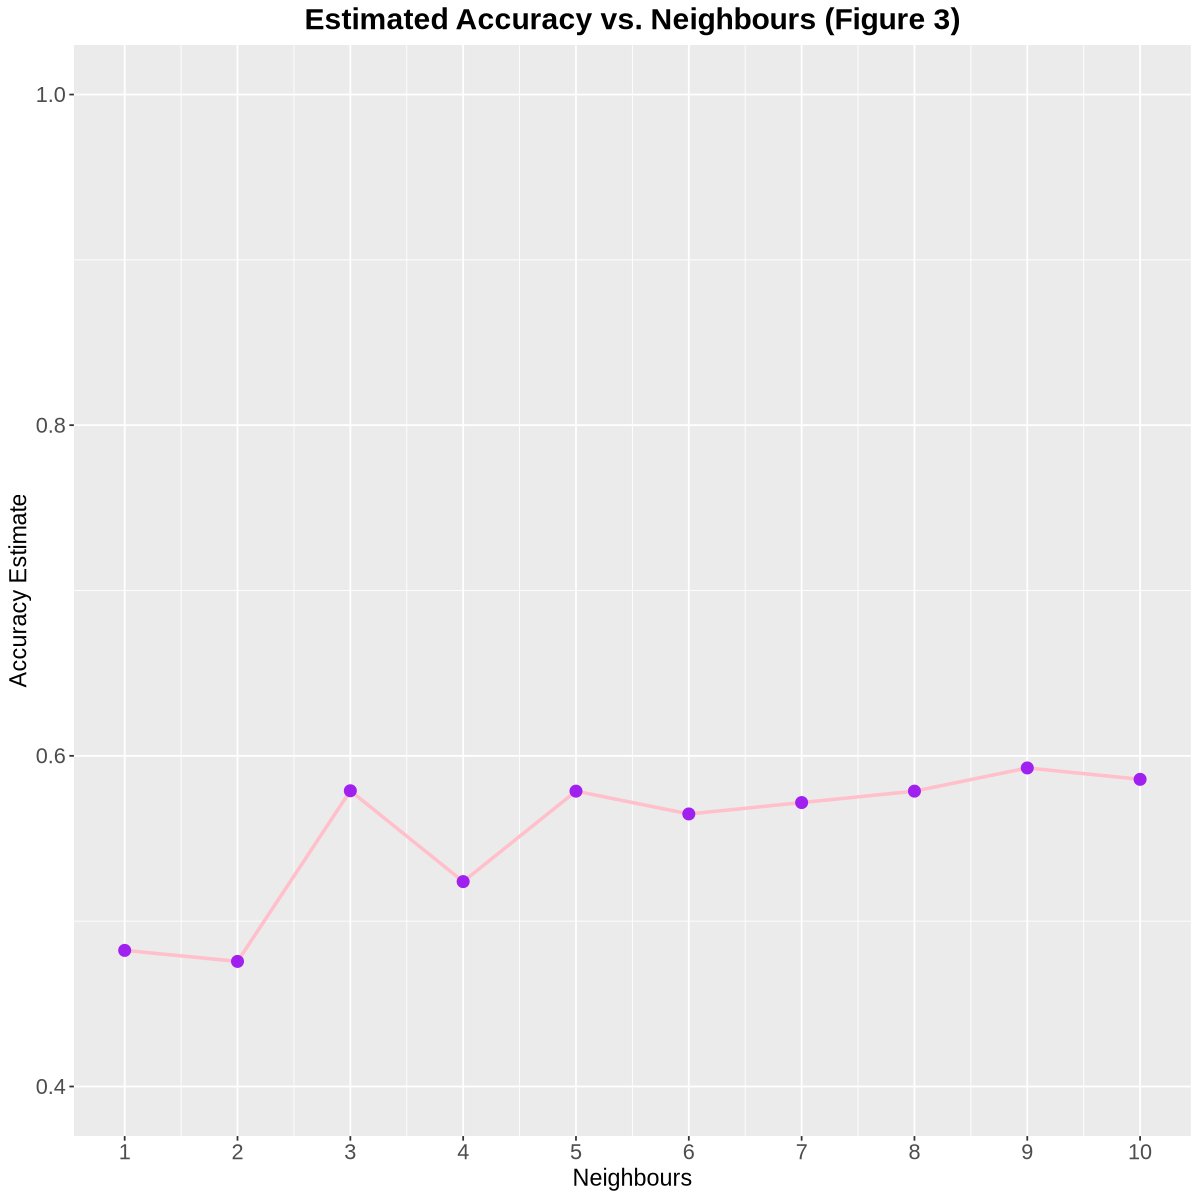

In [30]:
set.seed(123)
accuracy_versus_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
geom_line(color = "pink", linewidth = 1) +
geom_point(size = 3, color = "purple") +
labs(x = "Neighbours", y = "Accuracy Estimate") +
scale_x_continuous(breaks = seq(0, 14, by = 1)) +  
scale_y_continuous(limits = c(0.4, 1.0)) +
ggtitle("Estimated Accuracy vs. Neighbours (Figure 3)")+
theme(plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),  
axis.title = element_text(size = 14),                             
axis.text = element_text(size = 13))
accuracy_versus_k

Based on the visualization of the graph, we can see that the graph fluctuates between higher accuracy and lower accuracy. However, we can see that the point with the highest estimated accuracy is when k=9. This is the best k value. 

Even though the graph shows that the best k value is when k=9, we want to calculate the value. This is important as we could be reading the graph inccorectly. 

In [31]:
set.seed(123)
best_k <- accuracy |>
  slice_max(mean, n = 1)
best_k

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.5926765,5,0.0407097,Preprocessor1_Model09


With our new data we are going to create a new K-nearest neighbour classifier. We will still use the `nearest_neighbor()` function as well as use the "kknn" for the `set_engine()` function and the "classification" for the `set_mode()` function. However, since we now know the best k value, we will replace the `tune()` function with `neighbors=9`. Now we are going to train this classifier with the `workflow()` function, using our new classifier `best_k_spec`

In [32]:
set.seed(123)
best_k_spec<-nearest_neighbor(weight_func="rectangular", neighbors=9)|>
set_engine("kknn")|>
set_mode("classification")
best_k_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 9
  weight_func = rectangular

Computational engine: kknn 


In [33]:
set.seed(123)
best_k_fit<-workflow()|>
add_recipe(subscribe_recipe)|>
add_model(best_k_spec)|>
fit(data=training_data)
best_k_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3793103
Best kernel: rectangular
Best k: 9

Now that we have done our workflow, we are going to predict the data on the `testing_data`. We are going to use the `bind_cols` function to add the columns of the predictions into `the testing data` 

In [34]:
set.seed(123)
player_predictions=predict(best_k_fit, testing_data)|>
bind_cols(testing_data)
player_predictions

.pred_class,subscribe,played_hours,Age
<fct>,<fct>,<dbl>,<dbl>
TRUE,TRUE,3.8,17
FALSE,FALSE,0.0,17
TRUE,TRUE,0.7,21
TRUE,FALSE,0.0,21
FALSE,TRUE,0.0,17
⋮,⋮,⋮,⋮
TRUE,TRUE,0.4,17
TRUE,FALSE,0.2,17
FALSE,TRUE,0.0,17


Now that we have some predictions for our testing dataset, we are going to find the classifier's accuracy. To do this, we are going to use the `metrics()` function and specify that `truth=subscribe` and `estimate=.pred_class`. We are then going to format this metric so that it shows the results as a percentage. 

In [35]:
set.seed(123)
player_metrics <-player_predictions|>
metrics(truth = subscribe, estimate = .pred_class)
player_metrics
metrics_formatted <-player_metrics|>
mutate(.estimate = percent(.estimate, accuracy = 0.1))
metrics_formatted

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776
kap,binary,0.1949617


.metric,.estimator,.estimate
<chr>,<chr>,<chr>
accuracy,binary,69.4%
kap,binary,19.5%


This shows that our model is about 69.4% accurate, which is ok but can definitely be improved. Now that we know how accurate this model is, we are going to create a confusion matrix using the `conf_mat` function. With this, we can see where it's correct or incorrect. 

In [36]:
set.seed(123)
player_mat<-player_predictions|>
conf_mat(truth=subscribe, estimate = .pred_class)
player_mat

          Truth
Prediction FALSE TRUE
     FALSE     5    7
     TRUE      8   29

Finally we are going to calculate to precision and the recall percentages 

In [41]:
player_precision<- player_predictions |>
precision(truth = subscribe, estimate = .pred_class)|>
mutate(.estimate = percent(.estimate, accuracy = 0.1))
player_precision


player_recall<-player_predictions |>
recall(truth = subscribe, estimate = .pred_class)|>
mutate(.estimate = percent(.estimate, accuracy = 0.1))
player_recall

.metric,.estimator,.estimate
<chr>,<chr>,<chr>
precision,binary,41.7%


.metric,.estimator,.estimate
<chr>,<chr>,<chr>
recall,binary,38.5%


# **Discussion**

In this project, we aimed to predict whether a person would subscribe to a gaming-related newspaper based on their age and the number of hours they played the game. We did this using a k-nearest neighbour (KNN) classification model. We started off cleaning and preparing the data, then created visualizations in the form of histograms to analyze trends and patterns. The first histogram we created was comparing the age of the player and their subscription status (Figure 1). This figure showed that there was a significant trend between age and subscription. It showed that people under the age of 30 were likely to subscribe, with the highest number of subscribers falling in the age range of 15-20 years old. Next, we created a second histogram comparing the hours played and their subscription status (Figure 2). This histogram showed that subscribers generally tend to play more hours than non-subscribers, with the highest number of subscribers having played between 0 and 25 hours. 

After visualizing our data, we created a KNN classification model. We trained and validated our model using cross-validation to tune the number of neighbours and evaluate the test set. We then created an accuracy plot (Figure 3). From that plot, we could see that the best k value is k=9. Using this tuned model and the prediction on the training data, we found that the accuracy was 69.4%. This means that around 7 out of 10 player subscriptions were predicted correctly. While this accuracy is fairly decent and suggests that age and hours played are predictors of subscription status, it would be more beneficial to have a more accurate result. 

Lastly, we did a precision and recall test to understand where our predictions were wrong. The precision was 41.7%. This means that only 41.7% of the people predicted to have subscribed actually did. This indicates a high number of false positives. The recall we calculated was 38.5%. This means that the model correctly identified 38.5% of all actual subscribers. 

These results align with my prediction, as age and hours played are predictors that influence subscription status. However, the model we created is not very accurate at predicting. This model could be improved by adding more predictive variables such as player experience and gender.  

This project has opened the door to future questions such as:
1. Would adding other features like region or device used impact the prediction accuracy?
2. Does the prediction change depending on the time of the year? For example, are people more likely to subscribe in the winter when it's cold out or in the summer when it's warm 

